In [1]:
import cv2
import os
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
np.random.seed(42)

import tensorflow as tf
tf.compat.v1.reset_default_graph()


In [2]:
import keras
#from keras.utils import np_utils
from keras.models import Sequential, Model, Input
from keras.layers.core import Dense, Activation, Flatten, Dropout, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D,AveragePooling2D, ZeroPadding2D
from keras.layers import Input, Add
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [3]:
IMG_CHANNELS = 3
IMG_ROWS = 128
IMG_COLS = 128

#CONSTANT
BATCH_SIZE = 16
NB_EPOCH = 15
NB_CLASSES = 2
VERBOSE = 1
VALIDATION_SPLIT = 0.15
OPTIM = Adam(lr=0.005)  # Other optimizers are SGD, Adam, Adagrad

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip  '/content/gdrive/My Drive/Colab_Dataset/Dataset1.zip'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Archive:  /content/gdrive/My Drive/Colab_Dataset/Dataset1.zip
   creating: Dataset1/
  inflating: Dataset1/NonCOVID-CT-MetaInfo.csv  
  inflating: Dataset1/COVID-CT-MetaInfo.xlsx  
   creating: Dataset1/CT_NonCOVID/
  inflating: Dataset1/CT_NonCOVID/0.jpg  
  inflating: Dataset1/CT_NonCOVID/1%0.jpg  
  inflating: Dataset1/CT_NonCOVID/1%1.jpg  
  inflating: Dataset1/CT_NonCOVID/1%2.jpg  
  inflating: Dataset1/CT_NonCOVID/10%0.jpg  
  inflating: Dataset1/CT_Non

In [5]:
covid_data = pd.read_excel('Dataset1/COVID-CT-MetaInfo.xlsx')
noncovid_data = pd.read_csv('Dataset1/NonCOVID-CT-MetaInfo.csv')

image_location = []
image_label = []

for i in range(0,int(covid_data['File name'].size-1)):
    image_location.append('Dataset1/CT_COVID/CT_COVID/'  + covid_data['File name'][i])
    image_label.append(1)
    
for i in range(0,int(noncovid_data['image name'].size-1)):
    image_location.append('Dataset1/CT_NonCOVID/' + noncovid_data['image name'][i])
    image_label.append(0)


WIDTH = 128
HEIGHT = 128
def process_image():
    #Return two array. One of resized images and other of array of labels
    x = []  # array of images
    y = []  # array of labels
   
    
    for i in range(0,len(image_location)):
        #Read and resize image
        full_size_image = cv2.imread(image_location[i])
        x.append(cv2.resize(full_size_image,(WIDTH, HEIGHT),interpolation=cv2.INTER_CUBIC));
        # Labels
        y.append(image_label[i])
        
    return x,y

x,y = process_image()

In [18]:
x = np.asarray(x)
y = np.asarray(y)
print('Shape of x: ',x.shape, '  Shape of y: ', y.shape)
print('Dimension of x: ', x.ndim, '  Dimension of y: ', y.ndim)
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)
print('Shape of X_train: ',X_train.shape, '  Shape of y_train: ', y_train.shape)
print('Shape of X_test: ',X_test.shape, '  Shape of y_test: ', y_test.shape)

Shape of x:  (745, 128, 128, 3)   Shape of y:  (745,)
Dimension of x:  4   Dimension of y:  1
Shape of X_train:  (596, 128, 128, 3)   Shape of y_train:  (596,)
Shape of X_test:  (149, 128, 128, 3)   Shape of y_test:  (149,)


In [21]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
   # width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
   # height_shift_range=0.2,
    
    #zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode="nearest"
)


test_dataset = ImageDataGenerator(
    rescale = 1.0/255.0)



train_generator = train_datagen.flow(X_train,y_train, batch_size = BATCH_SIZE)



test_generator = test_dataset.flow(X_test,y_test, batch_size = BATCH_SIZE)


In [29]:
def CNN1(input_shape):
    X_input = Input(input_shape)
    
    # First Conv layer
    X = Conv2D(64,(3,3),padding='same', activation='relu')(X_input)
    X = Conv2D(64,(3,3),padding='same', activation='relu')(X)
    X = MaxPooling2D((2,2), strides=(2,2),padding='same')(X)
    
    # Second Conv layer
    X = Conv2D(128,(3,3),padding='same', activation='relu')(X)
    X = Conv2D(128,(3,3),padding='same', activation='relu')(X)
    X = MaxPooling2D((2,2), strides=(2,2),padding='same')(X)
    
    # Third Conv layer
    X = Conv2D(256,(3,3),padding='same', activation='relu')(X)
    X = Conv2D(256,(3,3),padding='same', activation='relu')(X)
    X = MaxPooling2D((2,2), strides=(2,2),padding='same')(X)
    
    # Fourth Conv layer
    X = Conv2D(256,(3,3),padding='same', activation='relu')(X)
    X = Conv2D(256,(3,3),padding='same', activation='relu')(X)
    X = MaxPooling2D((2,2), strides=(2,2),padding='same')(X)
    
    # Fifth Conv layer
   # X = Conv2D(512,(3,3),padding='same', activation='relu')(X)
   # X = Conv2D(512,(3,3),padding='same', activation='relu')(X)
    #X = MaxPooling2D((2,2), strides=(2,2),padding='same')(X)
    
    # Flatten layer
    X = Flatten()(X)
    
    # Dense layers
   # X = Dense(4096, activation='relu')(X)
   # X = Dropout(0.2)(X)
    X = Dense(512, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(256, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.4)(X)
    X = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='VGG13')
    
    return model

In [30]:
model = CNN1((128,128,3))
model.compile(optimizer=RMSprop(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "VGG13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 128)       0     

In [31]:
model_history = model.fit_generator(train_generator,epochs=100 ,validation_data=(test_generator))
                              

score = model.evaluate_generator(test_generator)
print('Test score: ', score[0])
print('Test accuracy: ', score[1])

Epoch 1/100
38/38 [==============================] - 5s 120ms/step - loss: 0.6948 - accuracy: 0.5084 - val_loss: 0.6918 - val_accuracy: 0.5369
Epoch 2/100
38/38 [==============================] - 4s 112ms/step - loss: 0.6929 - accuracy: 0.5084 - val_loss: 0.6860 - val_accuracy: 0.6107
Epoch 3/100
38/38 [==============================] - 4s 113ms/step - loss: 0.6669 - accuracy: 0.6342 - val_loss: 0.6842 - val_accuracy: 0.5839
Epoch 4/100
38/38 [==============================] - 4s 112ms/step - loss: 0.6480 - accuracy: 0.6745 - val_loss: 0.6346 - val_accuracy: 0.5906
Epoch 5/100
38/38 [==============================] - 4s 112ms/step - loss: 0.6054 - accuracy: 0.6728 - val_loss: 0.6137 - val_accuracy: 0.6443
Epoch 6/100
38/38 [==============================] - 4s 112ms/step - loss: 0.5978 - accuracy: 0.6896 - val_loss: 0.6796 - val_accuracy: 0.6779
Epoch 7/100
38/38 [==============================] - 4s 114ms/step - loss: 0.5769 - accuracy: 0.7215 - val_loss: 0.6698 - val_accuracy: 0.6913

Train Score:  0.009866626001894474
Train Accuracy:  0.9983221292495728


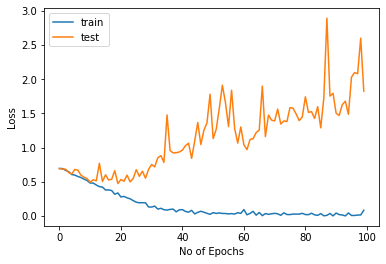

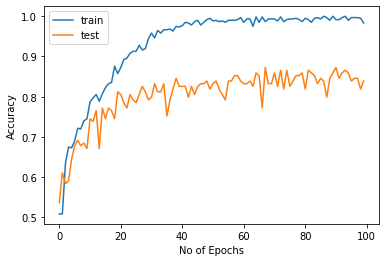

In [32]:
print('Train Score: ',model.evaluate_generator(train_generator)[0])
print('Train Accuracy: ',model.evaluate_generator(train_generator)[1])

plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# learning curves of model accuracy
plt.plot(model_history.history['accuracy'], label='train')
plt.plot(model_history.history['val_accuracy'], label='test')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
model.save('Saved Models/CNN1.h5')

In [36]:
os.path.getsize("/content/Saved Models/CNN1.h5")

87146152